# Knowledge Graphs - datasets quality review
### Analysis of the quality of top themes at data.europa.eu
##### Patryk Rakus, Michał Tomczyk

This notebook presents a sample analysis of the quality of datasets uploaded on the [data.europa.eu website](https://data.europa.eu/en) - an official European Union platform for collecting datasets. Here, we have focused on different themes, to try to compare the quality of datasets shared in them, according to FAIR principles. We have created separate files for acquiring features from the metadata of datasets, using python wrapper for SPARQL.

This analysis is based on the publishers analysis, with the changed scope to themes. Thus, the overall process and methods in this notebook are similar. For more detailed description, refer to the [publishers_analysis.ipynb file on the Github repo of our project](https://github.com/rakusp/KG24/blob/master/publishers_analysis.ipynb).

Initial setup:

In [1]:
from SPARQLWrapper import SPARQLWrapper
from utils import SPARQL_to_df
from FAIR import findability, accessibility, interoperability, reusability
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import pi


In [2]:
connection = SPARQLWrapper("https://data.europa.eu/sparql")

In [3]:
PREFIXES = """
    PREFIX dcat: <http://www.w3.org/ns/dcat#>
    PREFIX odp:  <http://data.europa.eu/euodp/ontologies/ec-odp#>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX void: <http://rdfs.org/ns/void#>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
"""


# Finding the top themes:

Similarly to the publishers analysis, we start by selecting the themes. Firstly we call a query for the top themes, but in the analysis we compare all themes.

In [4]:
query = '''
SELECT ?theme (count(*) as ?DatasetsPublished) WHERE {
    ?datasetURI a dcat:Dataset;
    dcat:theme ?theme .
}
GROUP BY ?theme
ORDER BY DESC(?DatasetsPublished)
'''

In [5]:
df = SPARQL_to_df(connection, query, PREFIXES)

In [6]:
df.iloc[:20]

,theme,DatasetsPublished
0,http://publications.europa.eu/resource/authori...,316172
1,http://publications.europa.eu/resource/authori...,264910
2,http://publications.europa.eu/resource/authori...,177407
3,http://publications.europa.eu/resource/authori...,152545
4,http://eurovoc.europa.eu/100145,147913
5,http://publications.europa.eu/resource/authori...,106065
6,http://publications.europa.eu/resource/authori...,100704
7,http://publications.europa.eu/resource/authori...,89630
8,http://publications.europa.eu/resource/authori...,78328
9,http://publications.europa.eu/resource/authori...,57156


In [7]:
df.iloc[:20]['DatasetsPublished'].astype('Int64').sum()

np.int64(1766613)

In [8]:
top_themes = list(df.iloc[10:30]['theme'])

In [9]:
newline = '\n'

In [10]:
query = f'''
VALUES ?theme {{
    {"".join(f"<{theme}>" + newline for theme in top_themes)}
    }}
    ?dataset a dcat:Dataset ;
           dcat:theme ?theme .
'''

name_query = f'''
VALUES ?theme {{
    {"".join(f"<{theme}>" + newline for theme in top_themes)}
    }}
    ?dataset a dcat:Dataset ;
           dcat:theme ?theme .
'''

obtain_names_query = PREFIXES + """
SELECT DISTINCT ?theme (SUBSTR(MIN(?name_en), 5) AS ?themeName)
WHERE {
    {
        SELECT DISTINCT ?theme
        WHERE {""" + name_query + """
        }
    }
  
  OPTIONAL {?theme foaf:name ?name1 .}
  OPTIONAL {?theme skos:prefLabel ?name2 .}
  BIND(COALESCE(?name2, ?name1, 'MISSING NAME') AS ?names)
  BIND(IF(LANG(?names) = 'en', CONCAT("aaaa", STR(?names)), CONCAT("zzzz", ?names)) AS ?name_en)
}
GROUP BY ?theme
"""

In [11]:
df_names = SPARQL_to_df(connection, obtain_names_query, PREFIXES)

In [12]:
df_names['themeName'] = df_names.apply(lambda x: x['themeName'] if x['themeName']!='MISSING NAME' else x['theme'][7:].strip('/'), axis=1)

# Calculate each category

As mentioned in publishers analysis, the functions extracting features related to FAIR principles can be used for different scopes of analysis. Here we demonstrate how the scope can be set to themes.

In [13]:
df_findability = findability.findability_aggregated_properties(connection, query, PREFIXES, 'theme')
df_findability = df_names.merge(df_findability, on='theme')
df_findability

,theme,themeName,totalDatasets,avgKeywords,percentageWithTitle,percentageWithIssuedDate,percentageWithLocation,percentageWithType,percentageWithPartOf
0,http://eurovoc.europa.eu/5079,land register,27497,1,100,0.574608139069717,100,99.919991271775103,47.968869331199767
1,http://standaarden.overheid.nl/owms/terms/Natu...,standaarden.overheid.nl/owms/terms/Natuur_en_m...,3051,1,100,0,0,0,0
2,http://eurovoc.europa.eu/100155,52 ENVIRONMENT,57146,1,100,11.089140097294649,99.993000384978826,99.917754523501207,86.48199349035803
3,https://data.gov.ie/Environment,data.gov.ie/Environment,4090,1,100,100,90.806845965770171,0,0
4,http://eurovoc.europa.eu/6416,eurovoc.europa.eu/6416,4289,1,100,0,100,0,0
5,http://eurovoc.europa.eu/100142,04 POLITICS,26653,1,99.996248077139534,3.297940194349604,99.988744231418602,99.921209619930214,93.813079203091584
6,http://eurovoc.europa.eu/4630,land use,9929,1,100,38.855876724745694,100,99.808641353610636,24.574478799476282
7,http://standaarden.overheid.nl/owms/terms/Econ...,standaarden.overheid.nl/owms/terms/Economie,2788,1,100,0,0,0,0
8,https://data.gov.ie/Government,data.gov.ie/Government,9779,1,99.989774005522037,100,3.742713978934451,0,0
9,http://publications.europa.eu/resource/authori...,Provisional data,10781,1,100,99.100268991744736,99.962897690381226,0.037102309618774,0


In [14]:
df_accessibility = accessibility.accessibility_aggregated_properties(connection, query, PREFIXES, 'theme')
df_accessibility = df_names.merge(df_accessibility, on='theme')
df_accessibility

,theme,themeName,totalDatasets,avgDistributionCount,percentageWithLicense,percentageWithAccessRights,percentageWithAccessURL,percentageWithDownloadURL
0,http://eurovoc.europa.eu/5079,land register,27497,1.001200130923373,0.17435524881947,0.112604431529241,0.17435524881947,0.108972030512169
1,http://standaarden.overheid.nl/owms/terms/Natu...,standaarden.overheid.nl/owms/terms/Natuur_en_m...,3051,4.042608980662078,99.537862818226042,1.078320090805902,99.537862818226042,0
2,http://eurovoc.europa.eu/100155,52 ENVIRONMENT,57146,1.013789241591712,2.848068491731971,0.008630510581006,3.091448890116339,0.005178306348604
3,https://data.gov.ie/Environment,data.gov.ie/Environment,4090,3.722249388753056,0.229900157645822,0.026274303730951,99.94088281660536,0
4,http://eurovoc.europa.eu/6416,eurovoc.europa.eu/6416,4289,1,100,100,100,100
5,http://eurovoc.europa.eu/100142,04 POLITICS,26653,1.006453307320002,1.494874184529357,0,1.629077353215284,0
6,http://eurovoc.europa.eu/4630,land use,9929,1.212810957800383,36.754691911642584,0.041521341969772,37.120079720976582,0
7,http://standaarden.overheid.nl/owms/terms/Econ...,standaarden.overheid.nl/owms/terms/Economie,2788,2.208393113342898,93.113529316225434,7.389962644144876,93.113529316225434,0
8,https://data.gov.ie/Government,data.gov.ie/Government,9779,4.004908477349422,0.676641813910734,0.084261056071903,99.992339903993463,0
9,http://publications.europa.eu/resource/authori...,Provisional data,10781,4.672572117614321,99.988089330024814,95.513647642679901,99.996029776674938,99.916625310173697


In [15]:
df_interoperability = interoperability.interoperability_aggregated_properties(connection, query, PREFIXES, 'theme')
df_interoperability = df_names.merge(df_interoperability, on='theme')
df_interoperability

,theme,themeName,totalDatasets,avgReferences,percentageWithLanguage,percentageWithAccessRights,percentageBeingVersionOf,percentageWithIdentifier,percentageWithRightsHolder
0,http://eurovoc.europa.eu/5079,land register,27497,1,99.96363239626141,0.018183801869295,0,99.898170709531949,4.120449503582209
1,http://standaarden.overheid.nl/owms/terms/Natu...,standaarden.overheid.nl/owms/terms/Natuur_en_m...,3051,1,100,1.573254670599803,0,0,0
2,http://eurovoc.europa.eu/100155,52 ENVIRONMENT,57146,1,99.548524831134288,0.003499807510587,0,99.508277044762538,7.932313722745249
3,https://data.gov.ie/Environment,data.gov.ie/Environment,4090,1,100,0,0,100,0
4,http://eurovoc.europa.eu/6416,eurovoc.europa.eu/6416,4289,1,0,100,0,100,0
5,http://eurovoc.europa.eu/100142,04 POLITICS,26653,1,99.711101939744119,0,0,99.380932728023112,2.5813229280006
6,http://eurovoc.europa.eu/4630,land use,9929,1,98.388558767247457,0,0,98.811562090844999,36.952361768556753
7,http://standaarden.overheid.nl/owms/terms/Econ...,standaarden.overheid.nl/owms/terms/Economie,2788,1,100,15.136298421807747,0,0,0
8,https://data.gov.ie/Government,data.gov.ie/Government,9779,1,100,0,0,100,0
9,http://publications.europa.eu/resource/authori...,Provisional data,10781,1,72.293850292180688,95.751785548650403,0,99.962897690381226,98.859103979222707


In [16]:
df_reusability = reusability.reusability_aggregated_properties(connection, query, PREFIXES, 'theme')
df_reusability = df_names.merge(df_reusability, on='theme')
df_reusability

,theme,themeName,totalDatasets,percentageWithConformsTo,percentageWithDescription,percentageWithProvenance,percentageWithIdentifier,percentageWithIssued,percentageWithRights,percentageWithFormat
0,http://eurovoc.europa.eu/5079,land register,27497,99.665418045604975,99.996363239626141,99.8581663454195,99.898170709531949,0.010897203051217,0.058118416273157,0.159825644751181
1,http://standaarden.overheid.nl/owms/terms/Natu...,standaarden.overheid.nl/owms/terms/Natuur_en_m...,3051,0,100,0,0,99.537862818226042,0,99.537862818226042
2,http://eurovoc.europa.eu/100155,52 ENVIRONMENT,57146,14.195219262940538,99.998250096244707,98.946557939313338,99.508277044762538,0.357303138053647,2.851520695964373,1.241067421548659
3,https://data.gov.ie/Environment,data.gov.ie/Environment,4090,90.537897310513447,100,40.488997555012225,100,99.980294272201787,0,99.546768260641093
4,http://eurovoc.europa.eu/6416,eurovoc.europa.eu/6416,4289,0,100,0,100,88.785264630449988,0,100
5,http://eurovoc.europa.eu/100142,04 POLITICS,26653,4.866243950024387,100,99.125801973511425,99.380932728023112,0.152842497670084,1.345759552656104,0.656104380242311
6,http://eurovoc.europa.eu/4630,land use,9929,70.11783664014503,100,98.489273844294491,98.811562090844999,1.727287825942534,36.74638764324863,25.734927752864973
7,http://standaarden.overheid.nl/owms/terms/Econ...,standaarden.overheid.nl/owms/terms/Economie,2788,0,100,0,0,93.113529316225434,0,93.113529316225434
8,https://data.gov.ie/Government,data.gov.ie/Government,9779,1.74864505573167,99.979548011044074,0.695367624501483,100,99.997446634664488,0,99.992339903993463
9,http://publications.europa.eu/resource/authori...,Provisional data,10781,98.775623782580466,100,0,99.962897690381226,99.78560794044665,98.896277915632754,99.998014888337469


In [25]:
df_reusability = reusability.reusability_aggregated_properties(connection, query, PREFIXES, 'theme')
df_reusability = df_names.merge(df_reusability, on='theme')
df_reusability

,theme,themeName,totalDatasets,percentageWithConformsTo,percentageWithDescription,percentageWithProvenance,percentageWithIdentifier,percentageWithIssued,percentageWithRights,percentageWithFormat
0,http://eurovoc.europa.eu/5079,land register,27497,99.665418045604975,99.996363239626141,99.8581663454195,99.898170709531949,0.010897203051217,0.058118416273157,0.159825644751181
1,http://standaarden.overheid.nl/owms/terms/Natu...,standaarden.overheid.nl/owms/terms/Natuur_en_m...,3051,0,100,0,0,99.537862818226042,0,99.537862818226042
2,http://eurovoc.europa.eu/100155,52 ENVIRONMENT,57146,14.195219262940538,99.998250096244707,98.946557939313338,99.508277044762538,0.357303138053647,2.851520695964373,1.241067421548659
3,https://data.gov.ie/Environment,data.gov.ie/Environment,4090,90.537897310513447,100,40.488997555012225,100,99.980294272201787,0,99.546768260641093
4,http://eurovoc.europa.eu/6416,eurovoc.europa.eu/6416,4289,0,100,0,100,88.785264630449988,0,100
5,http://eurovoc.europa.eu/100142,04 POLITICS,26653,4.866243950024387,100,99.125801973511425,99.380932728023112,0.152842497670084,1.345759552656104,0.656104380242311
6,http://eurovoc.europa.eu/4630,land use,9929,70.11783664014503,100,98.489273844294491,98.811562090844999,1.727287825942534,36.74638764324863,25.734927752864973
7,http://standaarden.overheid.nl/owms/terms/Econ...,standaarden.overheid.nl/owms/terms/Economie,2788,0,100,0,0,93.113529316225434,0,93.113529316225434
8,https://data.gov.ie/Government,data.gov.ie/Government,9779,1.74864505573167,99.979548011044074,0.695367624501483,100,99.997446634664488,0,99.992339903993463
9,http://publications.europa.eu/resource/authori...,Provisional data,10781,98.775623782580466,100,0,99.962897690381226,99.78560794044665,98.896277915632754,99.998014888337469


In [26]:
df_findability = df_findability.apply(pd.to_numeric, errors='ignore')
df_accessibility = df_accessibility.apply(pd.to_numeric, errors='ignore')
df_interoperability = df_interoperability.apply(pd.to_numeric, errors='ignore')
df_reusability = df_reusability.apply(pd.to_numeric, errors='ignore')

C:\Users\Patryk\AppData\Local\Temp\ipykernel_20972\1925042957.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_findability = df_findability.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_20972\1925042957.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_accessibility = df_accessibility.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_20972\1925042957.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_interoperability = df_interoperability.apply(pd.to_numeric, errors='ignore')
C:\Users\Patryk\AppData\Local\Temp\ipykernel_20972\1925042957.py:4: FutureWarning: 

#### Score calculation

Regardless of the scope of analysis, the same featurs are returned. Thus, the score is calculated in the same way as for the publishers analysis.

In [27]:
df_findability['avgKeywordsNormalized'] = df_findability['avgKeywords'].apply(lambda x: min(x, 1)) * 100
df_findability['findability_score'] = df_findability[['avgKeywordsNormalized', 'percentageWithTitle', 'percentageWithIssuedDate', 'percentageWithLocation', 'percentageWithType', 'percentageWithPartOf']].sum(axis=1)
df_findability['findability_score'] = df_findability['findability_score'] / 6

In [28]:
df_accessibility['avgDistributionCountNormalized'] = np.sqrt(df_accessibility['avgDistributionCount'] / df_accessibility['avgDistributionCount'].max()) * 100

df_accessibility['accessibility_score'] = df_accessibility[['avgDistributionCountNormalized', 'percentageWithLicense', 'percentageWithAccessRights', 'percentageWithAccessURL', 'percentageWithDownloadURL']].sum(axis=1)
df_accessibility['accessibility_score'] = df_accessibility['accessibility_score'] / 5

In [29]:
df_interoperability['avgReferencesNormalized'] = np.sqrt(df_interoperability['avgReferences'] / df_interoperability['avgReferences'].max()) * 100

df_interoperability['interoperability_score'] = df_interoperability[['avgReferencesNormalized', 'percentageWithLanguage', 'percentageWithAccessRights', 'percentageBeingVersionOf', 'percentageWithIdentifier', 'percentageWithRightsHolder']].sum(axis=1)
df_interoperability['interoperability_score'] = df_interoperability['interoperability_score'] / 6

In [30]:
df_reusability['reusability_score'] = df_reusability[['percentageWithConformsTo', 'percentageWithDescription', 'percentageWithProvenance', 'percentageWithIdentifier', 'percentageWithIssued', 'percentageWithRights', 'percentageWithFormat']].sum(axis=1)
df_reusability['reusability_score'] = df_reusability['reusability_score'] / 7

In [31]:
df = df_findability.merge(df_accessibility, on='theme').merge(df_interoperability, on='theme').merge(df_reusability, on='theme', suffixes=('', '_y'))
df = df[['themeName', 'findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score']]
df['overall_score'] = df[['findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score']].mean(axis=1)
df = df.apply(pd.to_numeric, errors='ignore')

C:\Users\Patryk\AppData\Local\Temp\ipykernel_20972\3829925305.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


# Plot results

Plotting is also the same regardless of the scope.

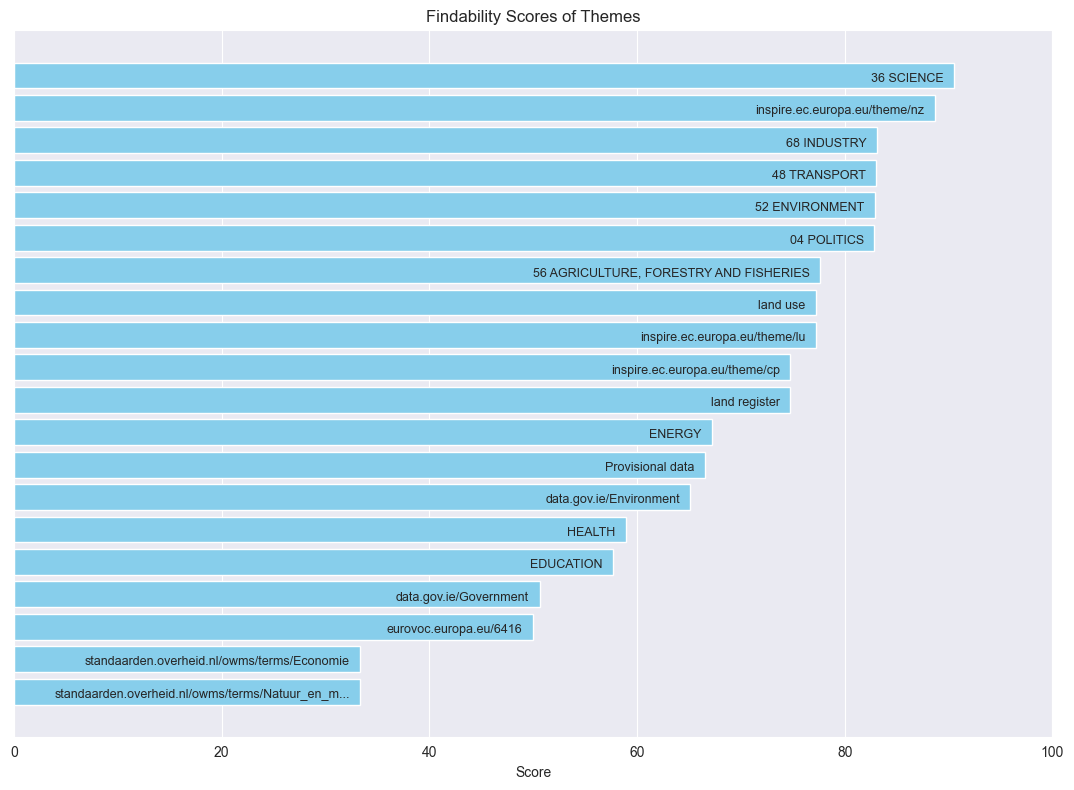

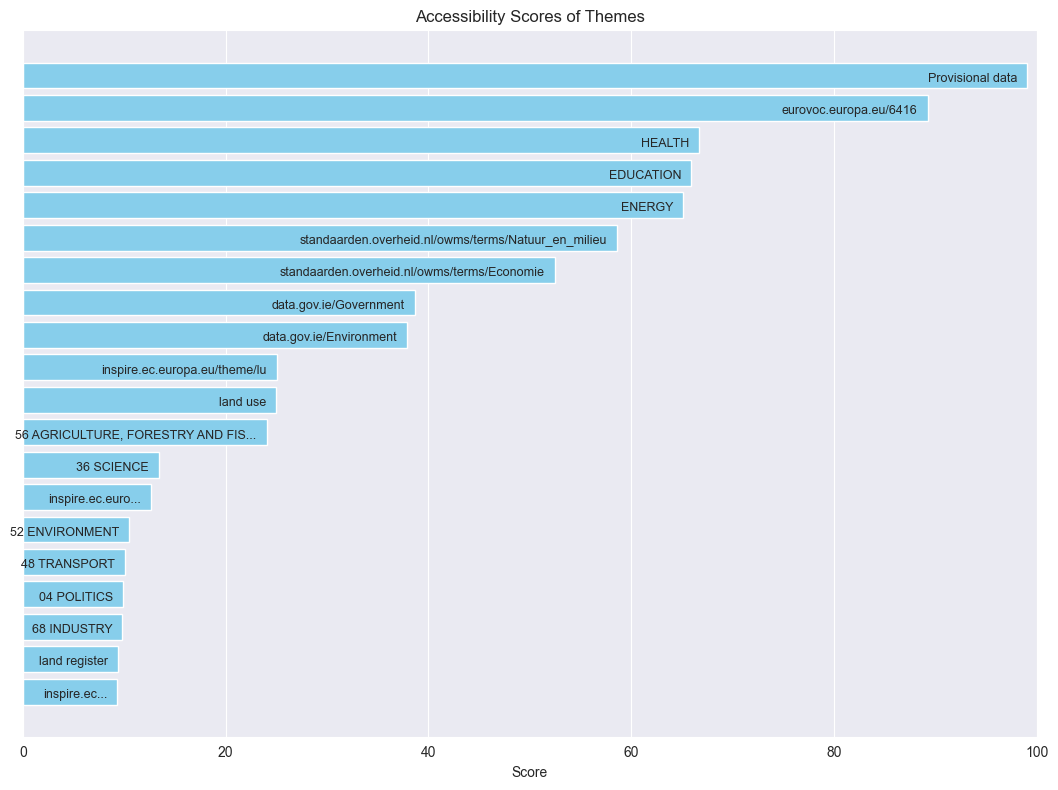

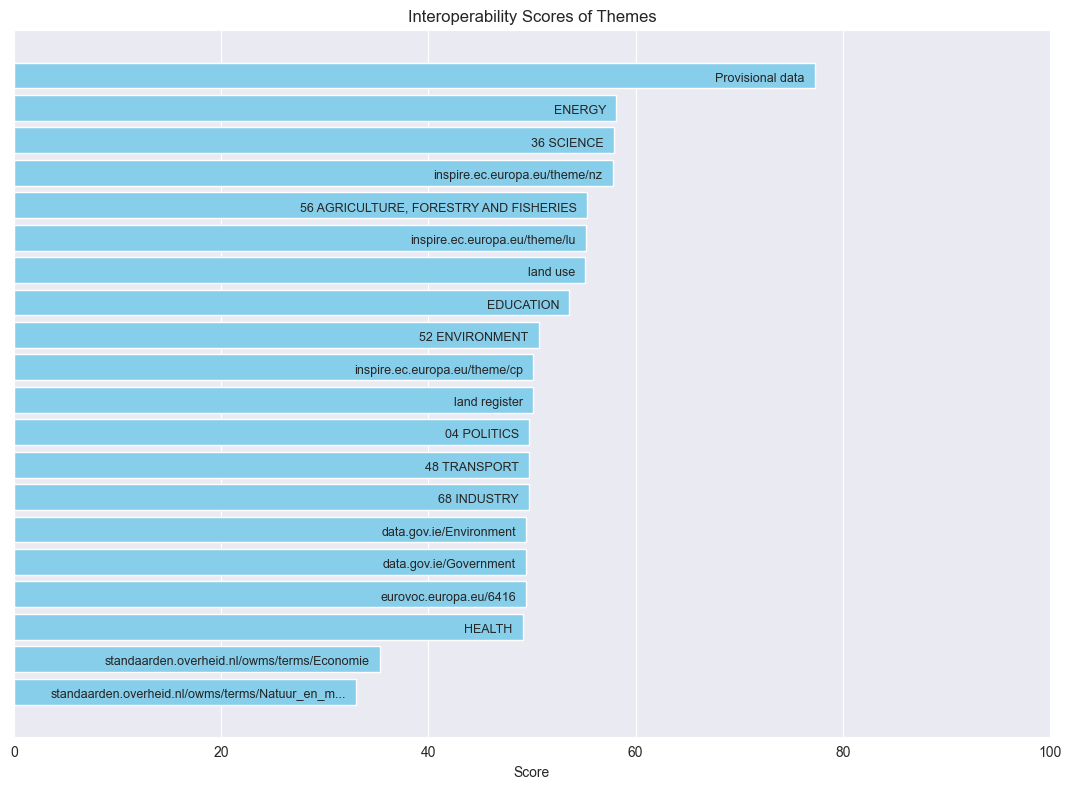

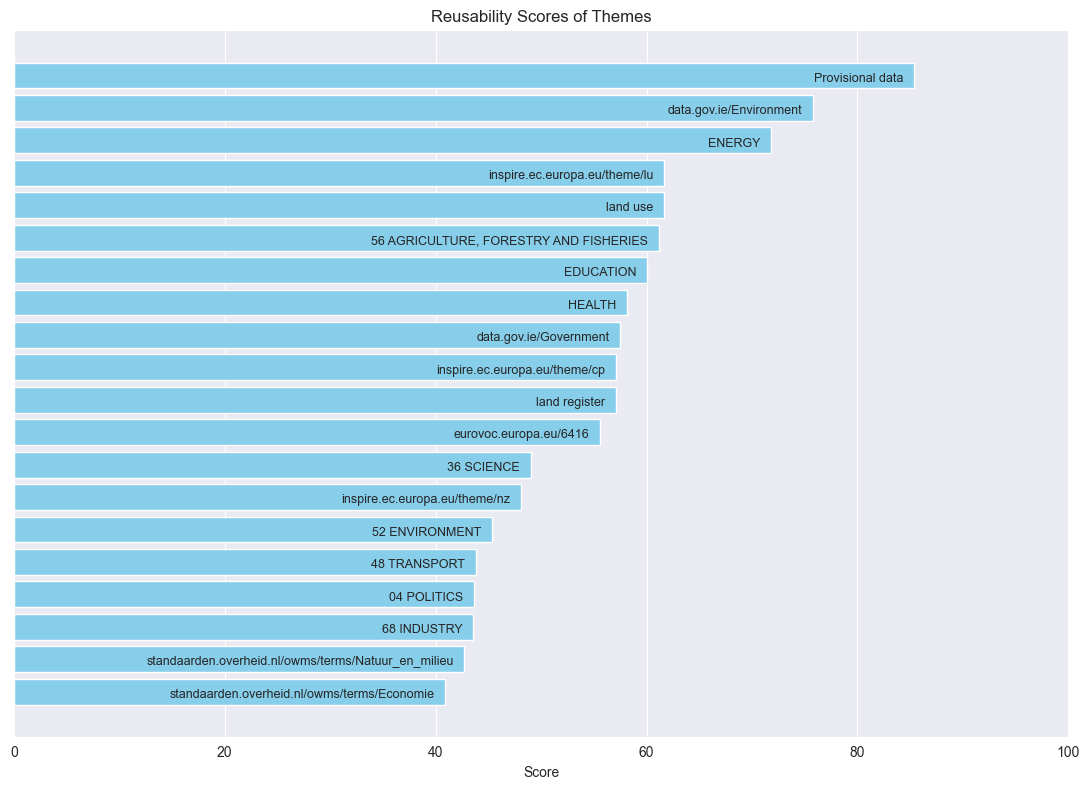

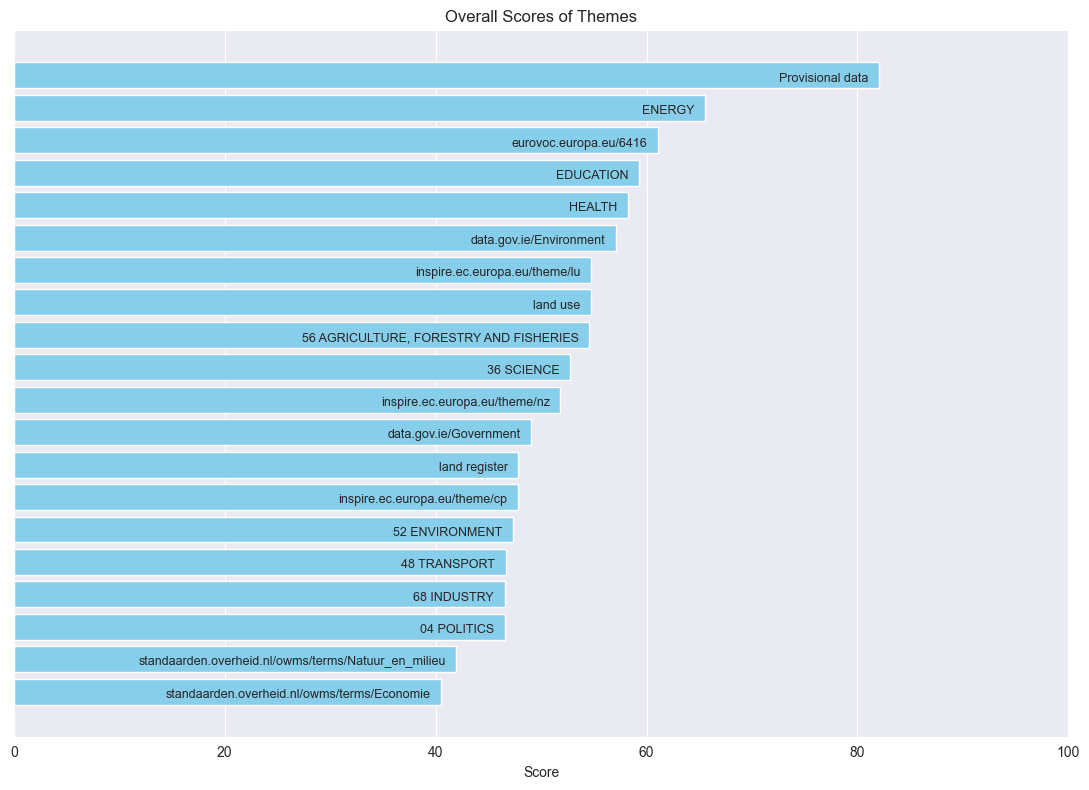

In [36]:
def plot_score(df, category, score_name):
    df_sorted = df.sort_values(by=score_name, ascending=True)
    
    plt.figure(figsize=(11, 8))
    bars = plt.barh(df_sorted['themeName'], df_sorted[score_name], color='skyblue')
    plt.gca().axes.get_yaxis().set_visible(False)
    for bar, name in zip(bars, df_sorted['themeName']):
        character_len=0.67
        if len(name) * character_len > bar.get_width():
            name = name[:(int(bar.get_width() / character_len) - 3)] + '...'
        plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height()/7, name, ha='right', va='bottom', rotation=0, fontsize=9)
    
    plt.ylabel('Theme Name')
    plt.xlabel('Score')
    plt.xlim(0, 100)
    plt.title(f'{category} Scores of Themes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
plot_score(df_findability, 'Findability', 'findability_score')
plot_score(df_accessibility, 'Accessibility', 'accessibility_score')
plot_score(df_interoperability, 'Interoperability', 'interoperability_score')
plot_score(df_reusability, 'Reusability', 'reusability_score')

plot_score(df, 'Overall', 'overall_score')

In [ ]:
def spider_plot(df, category_names, category_vars, main_score, title):
    N = len(category_names)
    values_worst = df.sort_values(by=main_score, ascending=True)[category_vars].iloc[0].tolist()
    values_worst += values_worst[:1]
    values = df[category_vars].mean().tolist()
    values += values[:1]
    
    values_best = df.sort_values(by=main_score, ascending=False)[category_vars].iloc[0].tolist()
    values_best += values_best[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], category_names)
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle < pi / 2 or angle > 3 * pi / 2:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
        x, y = label.get_position()
        # label.set_position((x, y + 0.1))
    
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=7)
    plt.ylim(0, 100)
    
    ax.plot(angles, values_worst, linewidth=1, color='red', linestyle='solid', label='Worst Theme\'s Scores')
    ax.plot(angles, values, linewidth=1, color='orange', linestyle='solid', label='Average Scores')
    ax.plot(angles, values_best, linewidth=1, color='green', linestyle='solid', label='Best Theme\'s Scores')
    
    ax.fill(angles, values_worst, 'red', alpha=0.1)
    ax.fill(angles, values, 'orange', alpha=0.1)
    ax.fill(angles, values_best, 'green', alpha=0.1)
    plt.title(title, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

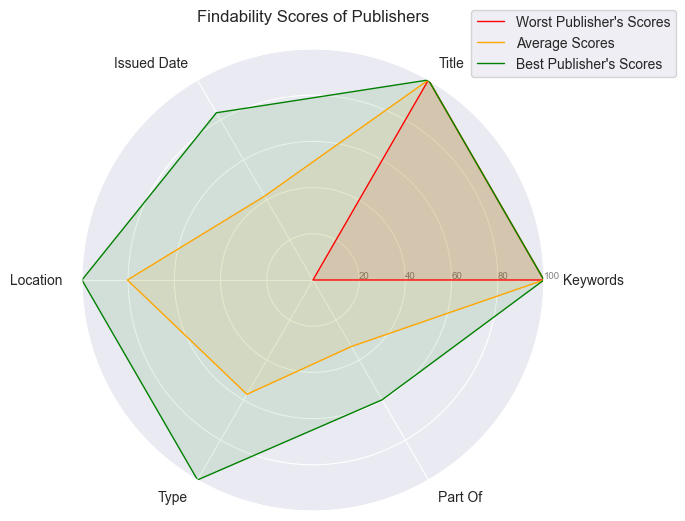

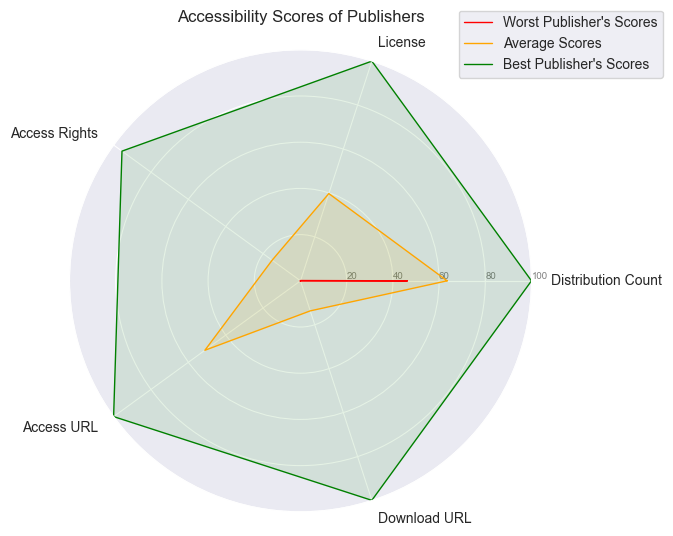

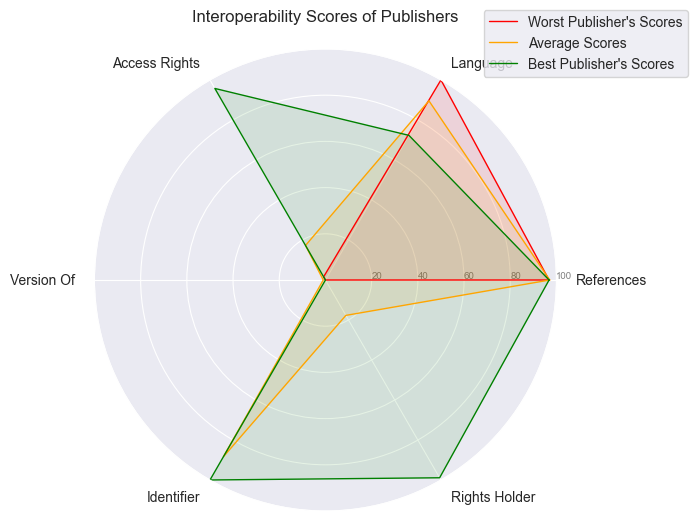

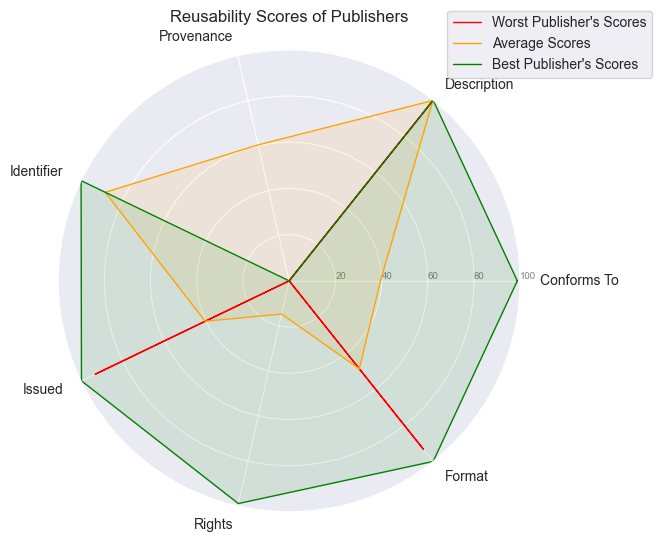

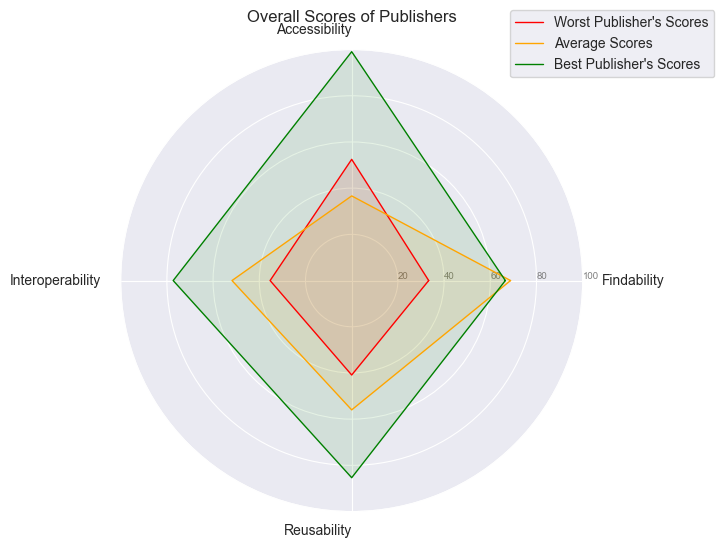

In [33]:
spider_plot(df_findability, ['Keywords', 'Title', 'Issued Date', 'Location', 'Type', 'Part Of'], ['avgKeywordsNormalized', 'percentageWithTitle', 'percentageWithIssuedDate', 'percentageWithLocation', 'percentageWithType', 'percentageWithPartOf'], 'findability_score', 'Findability Scores of Themes')

spider_plot(df_accessibility, ['Distribution Count', 'License', 'Access Rights', 'Access URL', 'Download URL'], ['avgDistributionCountNormalized', 'percentageWithLicense', 'percentageWithAccessRights', 'percentageWithAccessURL', 'percentageWithDownloadURL'], 'accessibility_score', 'Accessibility Scores of Themes')

spider_plot(df_interoperability, ['References', 'Language', 'Access Rights', 'Version Of', 'Identifier', 'Rights Holder'], ['avgReferencesNormalized', 'percentageWithLanguage', 'percentageWithAccessRights', 'percentageBeingVersionOf', 'percentageWithIdentifier', 'percentageWithRightsHolder'], 'interoperability_score', 'Interoperability Scores of Themes')

spider_plot(df_reusability, ['Conforms To', 'Description', 'Provenance', 'Identifier', 'Issued', 'Rights', 'Format'], ['percentageWithConformsTo', 'percentageWithDescription', 'percentageWithProvenance', 'percentageWithIdentifier', 'percentageWithIssued', 'percentageWithRights', 'percentageWithFormat'], 'reusability_score', 'Reusability Scores of Themes')

spider_plot(df, ['Findability', 'Accessibility', 'Interoperability', 'Reusability'], ['findability_score', 'accessibility_score', 'interoperability_score', 'reusability_score'], 'overall_score', 'Overall Scores of Themes')